In [1]:
import pandas as pd
import numpy as np
import glob, os

from seahorse import Graph, SContainer
from seahorse import constants
constants.SHOWMODE = True

cpal = ["#90ee90", "#6495ed", "#ca472f", "#f6c85f", "#6f4e7c", "#ffa056", "#558254", "#4ad9e1"]
cdef = "#9dbcd4"

cpalLib = cpal[:3]
cpalQual = [cpal[5], cpal[3], cpal[4]]

import matplotlib as mpl
mpl.rcParams['svg.fonttype'] = 'none' # Output SVG with text as text, not curves
mpl.rcParams['savefig.transparent'] = True # Save w/ transparent background by default

In [2]:
def save_replace_excel(fname, df, sheetname):
    with pd.ExcelWriter(fname, mode='a') as writer:  
        workBook = writer.book
        try:
            workBook.remove(workBook[sheetname])
        except:
            print("worksheet doesn't exist")
        finally:
            df.to_excel(writer, sheet_name=sheetname, index=False)
    
excelpath = '../../../nr-source-data.xlsx'
save_replace_excel_spmp = lambda df, sheetname: save_replace_excel(excelpath, df, sheetname)

In [3]:
fname = '../tables/bracken_self_combine_result.tsv.gz'
df = pd.read_csv(fname, sep='\t', index_col=0, compression='gzip')
df.head()

,abundance,#covered,#assigned,rank,taxid,name,sample
0,100.00,25533903,0,R,1,root,SPMP16
1,100.00,25533903,0,R1,131567,cellular organisms,SPMP16
2,100.00,25533903,0,D,2,Bacteria,SPMP16
3,7.64,1949691,1949691,S,2820084,SPMP45_bin.219.fasta,SPMP16
4,7.27,1856540,1856540,S,2820142,SPMP41_bin.4.fasta,SPMP16


Don't get confused here, it's normal that the SPMP label in the name is not the same than the sample name
- **name**: binID used as label for the SLC ID in the kraken database
- **sample**: name of the sample where the reads came from

In [4]:
fname = '../tables/mags_info_hybrid.tsv'
minfo = pd.read_csv(fname, sep='\t', index_col=0, usecols=[0, 1, 2, 3, 13])
minfo['name'] = minfo['name'] + '.fasta'
minfo.head()

,name,genus,species,SLCID
0,SPMP01_bin.12.fasta,Mitsuokella,Mitsuokella multacida,47
1,SPMP01_bin.13.fasta,Enterococcus_A,Enterococcus_A avium,420
2,SPMP01_bin.16.fasta,Olsenella_E,Olsenella_E sp003609875,111
3,SPMP01_bin.17.fasta,Megasphaera,Megasphaera sp000417505,220
4,SPMP01_bin.20.fasta,Akkermansia,Akkermansia muciniphila,260


In [5]:
fname = '../tables/subjects_metadata.tsv'
sdata = pd.read_csv(fname, sep='\t', index_col=0)

sdata = sdata[['Subject', 'Age', 'Sexe', 'Ethnicity']]
sdata.columns = ['sample', 'age', 'sexe', 'ethnicity']

sdata.head()

,sample,age,sexe,ethnicity
17,SPMP01,57,M,Indian
18,SPMP02,52,F,Indian
19,SPMP03,52,F,Indian
22,SPMP04,48,M,Indian
23,SPMP05,54,F,Malay


In [6]:
sdf = df[df['rank'] == 'S']
sdf = sdf.merge(minfo, on='name', how='left')
sdf = sdf.merge(sdata, on='sample', how='left')
sdf

,abundance,#covered,#assigned,rank,taxid,name,sample,genus,species,SLCID,age,sexe,ethnicity
0,7.64,1949691,1949691,S,2820084,SPMP45_bin.219.fasta,SPMP16,Prevotella,Prevotella copri,566,68,F,Indian
1,7.27,1856540,1856540,S,2820142,SPMP41_bin.4.fasta,SPMP16,Prevotella,Prevotella copri_A,95,68,F,Indian
2,4.02,1026468,1026468,S,2820015,SPMP06_bin.94.fasta,SPMP16,Faecalibacterium,Faecalibacterium prausnitzii_C,54,68,F,Indian
3,3.86,985317,985317,S,2820217,SPMP07_bin.56.fasta,SPMP16,Faecalibacterium,Faecalibacterium prausnitzii,20,68,F,Indian
4,3.75,957301,957301,S,2820436,SPMP15_bin.16.fasta,SPMP16,Blautia_A,Blautia_A massiliensis,50,68,F,Indian
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74424,0.00,28,28,S,2820046,SPMP42_bin.34.fasta,SPMP99,Haemophilus_D,Haemophilus_D parainfluenzae,659,60,M,Chinese
74425,0.00,25,25,S,2820546,SPMP96_bin.25.fasta,SPMP99,Haemophilus_D,Haemophilus_D sp001815355,323,60,M,Chinese
74426,0.00,20,20,S,2820287,SPMP84_bin.92.fasta,SPMP99,CAG-594,CAG-594 sp000434835,669,60,M,Chinese
74427,0.00,19,19,S,2820242,SPMP01_bin.7.fasta,SPMP99,Enterococcus_C,Enterococcus_C asini,502,60,M,Chinese


## MaAsLin2

### Prepare data

In [7]:
!mkdir /tmp/maaslin2

mkdir: cannot create directory ‘/tmp/maaslin2’: File exists


In [8]:
matrix = sdf.groupby(['genus', 'sample'])["abundance"].sum().rename('abundance').reset_index()
matrix = pd.pivot_table(sdf, index='sample', columns='genus', values='abundance', fill_value=0)

outfile = "../tmp/maaslin2/bracken_self_combine_result.genus_sum.matrix.tsv"
matrix.to_csv(outfile, sep="\t")
matrix

genus,51-20,AM51-8,Acetatifactor,Acidaminococcus,Acutalibacter,Adlercreutzia,Agathobacter,Agathobaculum,Akkermansia,Alistipes,...,UMGS1773,UMGS1781,UMGS1783,UMGS1820,UMGS1975,UMGS902,UMGS911,UMGS973,Veillonella_A,Weissella
sample,,,,,,,,,,,,,,,,,,,,,
SPMP01,0.0,0.000,0.000,0.210,0.016667,0.000,0.003333,0.000000,0.340,0.001667,...,0.005,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.000
SPMP02,0.0,0.005,0.035,0.000,0.010000,0.000,0.883333,0.001667,0.000,0.006667,...,0.000,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.010
SPMP03,0.0,0.010,0.665,0.002,0.110000,0.085,4.293333,0.111667,0.278,0.168333,...,0.070,0.0,0.00,0.00,0.00,0.00,0.02,0.02,0.000,0.005
SPMP04,0.0,0.000,0.035,0.014,0.006667,0.025,1.056667,0.050000,0.000,0.180000,...,0.000,0.0,0.00,0.00,0.02,0.00,0.00,0.01,0.005,0.000
SPMP05,0.0,0.010,0.190,0.352,0.013333,0.270,1.403333,0.045000,0.020,0.270000,...,0.095,0.0,0.01,0.01,0.05,0.01,0.00,0.18,0.000,0.010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SPMP95,0.0,0.005,0.010,0.954,0.003333,0.000,0.023333,0.080000,0.000,1.256667,...,0.000,0.0,0.00,0.00,0.00,0.00,0.00,0.02,0.000,0.000
SPMP96,0.0,0.000,0.485,0.008,0.003333,0.000,0.100000,0.060000,0.000,0.038333,...,0.025,0.0,0.00,0.00,0.00,0.00,0.00,0.01,0.000,0.010
SPMP97,0.0,0.065,0.130,0.028,0.010000,0.005,2.023333,0.073333,0.014,0.050000,...,0.060,0.0,0.00,0.00,0.00,0.00,0.00,0.05,0.000,0.505


**MaAsLin2 is run in `maaslin3_run.ipynb`**

## Supplementary figure 7 - MaAsLin2 results

In [9]:
def read_maaslin_eth(fname):
    ref = os.path.basename(os.path.dirname(fname).split('_')[4]).title()
    df = pd.read_csv(fname, sep='\t')
    df['ref'] = df['metadata'].apply(lambda metadata: ref if metadata == 'Ethnicity' else 'None')
    return df

fnames = [
    '../tmp/maaslin2/abundance_genus_mean_cplm_chinese/significant_results.tsv',
    '../tmp/maaslin2/abundance_genus_mean_cplm_indian/significant_results.tsv',
    '../tmp/maaslin2/abundance_genus_mean_cplm_malay/significant_results.tsv'
]

sigres = pd.concat([
    read_maaslin_eth(fname) for fname in fnames
])

sigres['id'] = sigres[['feature', 'value', 'ref']].apply(lambda row: hash(tuple(sorted(row.values))), axis=1)
sigres = sigres.drop_duplicates('id')

sigres = sigres[['feature', 'metadata', 'value', 'ref', 'coef', 'stderr', 'pval', 'qval']].sort_values('pval')
sigres.columns = ['Genus', 'Feature', 'Value', 'Reference', 'Coefficient', 'StandardError', 'pValue', 'qValue']

sigres.head()

,Genus,Feature,Value,Reference,Coefficient,StandardError,pValue,qValue
0,UBA11524,Ethnicity,Malay,Chinese,-3.202140,0.723126,0.000024,0.019301
1,UBA7748,Ethnicity,Indian,Chinese,2.343642,0.560179,0.000060,0.024621
0,Negativibacillus,Ethnicity,Malay,Indian,1.459321,0.364388,0.000117,0.032039
2,Schaedlerella,Ethnicity,Indian,Chinese,-0.739339,0.184668,0.000117,0.032039
3,Bacteroides,Ethnicity,Malay,Chinese,-0.864544,0.223660,0.000193,0.039629


In [10]:
abu = sdf.groupby(['genus', 'sample', 'ethnicity'])["abundance"].sum().rename('abundance').reset_index()
mabu = abu.groupby('genus')['abundance'].sum().rename('abundance').sort_values(ascending=False)
top10 = list(mabu.head(10).index)
mabu.head(10)

genus
Bifidobacterium     1367.47
Blautia_A           1026.18
Faecalibacterium     869.38
Agathobacter         526.74
Bacteroides          524.76
Collinsella          434.57
Phocaeicola          432.15
Prevotella           323.77
Dorea                290.93
Gemmiger             286.03
Name: abundance, dtype: float64

In [11]:
saf = sigres[(sigres['Genus'].str.strip().isin(set(top10))) & (sigres['Feature'].str.strip() == 'Ethnicity')]
saf = saf[['Genus', 'Value', 'Reference', 'pValue']]
saf = saf.to_records(index=False)
saf

rec.array([('Bacteroides', 'Malay', 'Chinese', 0.00019331),
           ('Bifidobacterium', 'Indian', 'Chinese', 0.00055083),
           ('Collinsella', 'Malay', 'Chinese', 0.0038089 ),
           ('Bacteroides', 'Indian', 'Chinese', 0.0070325 ),
           ('Dorea', 'Malay', 'Indian', 0.00830393),
           ('Phocaeicola', 'Indian', 'Chinese', 0.01677258),
           ('Collinsella', 'Malay', 'Indian', 0.02441124),
           ('Dorea', 'Indian', 'Chinese', 0.0335389 )],
          dtype=[('Genus', 'O'), ('Value', 'O'), ('Reference', 'O'), ('pValue', '<f8')])

In [12]:
from collections import defaultdict

def get_panno_star(pvalue):
    annos = [[1e-4, "****"], [1e-3, "***"], [1e-2, "**"], [0.05, "*"]]
    for anno, name in annos:
        if pvalue <= anno:
            return name
    return 'ns'

def add_pvalue_hue(ax, pdata, odata, x, y, hue):
    # https://stackoverflow.com/questions/36578458/how-does-one-insert-statistical-annotations-stars-or-p-values-into-matplotlib
    
    sumx = odata.groupby(x)[y].max().to_dict()
    xorder = list(odata.sort_values(x)[x].unique())
    
    horder = list(odata.sort_values(hue)[hue].unique())
    # need to change that, don't have time right now
    horder = {horder[0]: -.3, horder[1]: 0, horder[2]: .3}
    
    height = (ax.get_ylim()[1] - ax.get_ylim()[0]) / 20
    found = defaultdict(int)
    
    for x, h1, h2, pvalue in pdata:
        xidx = xorder.index(x)
        h1idx = horder[h1]
        h2idx = horder[h2]       
        
        x1 = xidx + h1idx
        x2 = xidx + h2idx
        
        xheight = height * found[x] * 2
        found[x] += 1
        
        y1 = sumx[x] + xheight + height
        y2 = sumx[x] + xheight + height * 1.5
        y3 = sumx[x] + xheight + height * 1.5
        
        ax.plot([x1, x1, x2, x2], [y1, y2, y2, y1], lw=1.5, color='black')
        
        star = get_panno_star(pvalue)
        ax.text((x1 + x2) * .5, y3, star, ha='center', va='bottom')

/home/jsgounot/anaconda3/envs/graphic/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jsgounot/anaconda3/envs/graphic/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


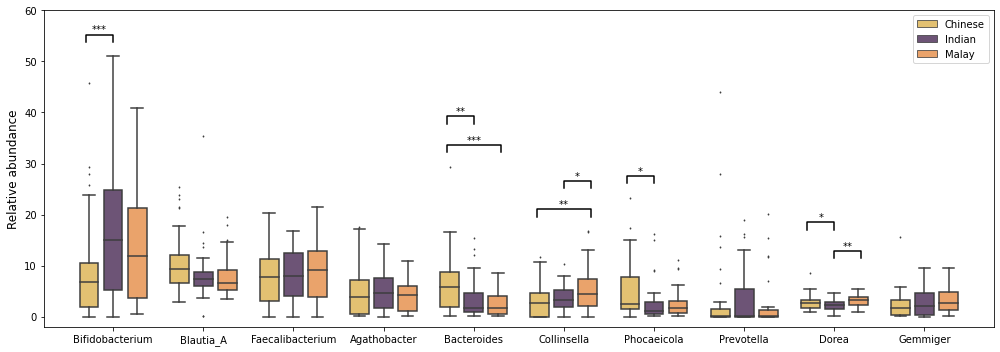

In [13]:
abu_top10 = abu[abu['genus'].isin(set(top10))]

abu_top10['genus'] = pd.Categorical(abu_top10['genus'], categories=top10)
abu_top10['ethnicity'] = pd.Categorical(abu_top10['ethnicity'], categories=['Chinese', 'Indian', 'Malay'])

graph = Graph(abu_top10)
graph.sns.boxplot(x='genus', y='abundance', hue='ethnicity', palette=cpal[3:], fliersize=1)
graph.change_boxplot_width(.8)

add_pvalue_hue(graph.ax, saf, abu_top10,  x="genus", y="abundance", hue="ethnicity")

graph.ax.set_ylim(-2, 60)

graph.ax.set_xlabel('')
graph.ax.set_ylabel('Relative abundance', size=12)
graph.ax.legend(title='')

graph.set_size_inches(14, 5)
graph.tight_layout()
graph.save('../img/sf7.pdf')

In [14]:
subabu = abu.pivot_table(index=['sample', 'ethnicity'], columns='genus', values='abundance')
save_replace_excel_spmp(subabu, 'SFig 7')

## Supplementary figure 11.A

In [15]:
def set_label(row):
    if row['label'] == 'null':
        return 'SLC ' + str(row['SLCID'])
    else:
        return row['species']

ssdf = sdf.copy()
ssdf['label'] = ssdf['species'].fillna('null')
ssdf['label'] = ssdf.apply(set_label, axis=1)

species_median = ssdf.groupby('label')['abundance'].median()
top10 = species_median.sort_values(ascending=False).head(10)
top10

label
Blautia_A wexlerae                 2.63
Bifidobacterium adolescentis       2.63
Fusicatenibacter saccharivorans    1.93
Phocaeicola vulgatus               1.33
Bifidobacterium longum             1.13
Agathobacter faecis                1.09
Blautia_A massiliensis             1.00
SLC 612                            0.82
Faecalibacterium prausnitzii_D     0.77
Faecalibacterium prausnitzii_G     0.73
Name: abundance, dtype: float64

/home/jsgounot/anaconda3/envs/graphic/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


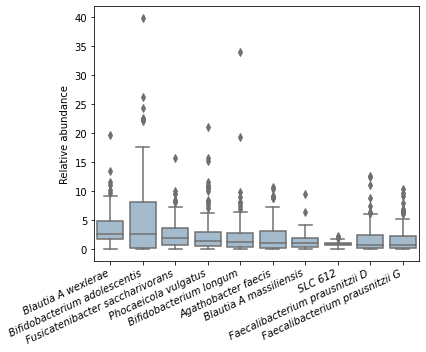

In [16]:
top_abu = ssdf[ssdf['label'].isin(set(list(top10.index)))]
top_abu['label'] = pd.Categorical(top_abu['label'], categories=list(top10.index))

cdef = "#9dbcd4"

graph = Graph(top_abu)
graph.sns.boxplot(x='label', y='abundance', color=cdef)

sclean = lambda name: name.replace('_', ' ')
graph.apply_xticklabels(sclean, rotation=25, ha='right', style='italic')
graph.ax.set_xlabel('')
graph.ax.set_ylabel('Relative abundance')

graph.set_size_inches(6, 5)
graph.tight_layout()
graph.save('../img/sf11.A.pdf')

In [17]:
sub = ssdf[['abundance', '#covered', '#assigned', 'taxid', 'sample',
       'genus', 'species', 'SLCID', 'age', 'sexe', 'ethnicity', 'label']]

save_replace_excel_spmp(sub, 'SFig 11.A')
sub.head()

,abundance,#covered,#assigned,taxid,sample,genus,species,SLCID,age,sexe,ethnicity,label
0,7.64,1949691,1949691,2820084,SPMP16,Prevotella,Prevotella copri,566,68,F,Indian,Prevotella copri
1,7.27,1856540,1856540,2820142,SPMP16,Prevotella,Prevotella copri_A,95,68,F,Indian,Prevotella copri_A
2,4.02,1026468,1026468,2820015,SPMP16,Faecalibacterium,Faecalibacterium prausnitzii_C,54,68,F,Indian,Faecalibacterium prausnitzii_C
3,3.86,985317,985317,2820217,SPMP16,Faecalibacterium,Faecalibacterium prausnitzii,20,68,F,Indian,Faecalibacterium prausnitzii
4,3.75,957301,957301,2820436,SPMP16,Blautia_A,Blautia_A massiliensis,50,68,F,Indian,Blautia_A massiliensis
